# Supporting target / coupling map in HighLevelSynthesis and TokenSwapper synthesis plugin for permutations

In short:
* Extending high-level-synthesis interface to support target / coupling_map
* Showcasing this for synthezing permutation gates

Contact: Alexander Ivrii (Sasha), alexi@il.ibm.com

### Why do we want connectivity-aware synthesis algorithms

* One possible application: _resynthesizing blocks of gates in Qiskit's optimization loop_

  * We already resynthesize blocks of 1-qubit and/or 2-qubit gates
  * May want to resynthesize blocks of SWAP-gates, etc.


### Recap

In [1]:
# imports

from qiskit.circuit import QuantumCircuit

from qiskit.circuit.library import PermutationGate

from qiskit.transpiler.passes.synthesis.high_level_synthesis import (
    HighLevelSynthesis,
    HighLevelSynthesisPluginManager,
    HighLevelSynthesisPlugin,
    HLSConfig,
)

from qiskit.compiler import transpile

from qiskit.transpiler import CouplingMap

---

**Adding high-level objects on a quantum circuit**

* We can add "high-level objects" on a quantum circuit, such as `Clifford`s, `LinearFunction`s or `PermutationGate`s.

---

**PermutationGate**
* only stores the "permutation pattern", which specifies the new qubit locations after applying the permutation: 
* e.g., `PermutationGate([1, 2, 3, 4, 0])` means that 1->0, 2->1, 3->2, 4->3, 0->4 (this is a cyclic shift).
* a `PermutationGate` _does not store_ how it should be synthesized (in particular, it does not have `definition`).

--- 

**Main running example: quantum circuit with a single permutation gate**

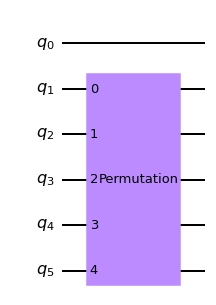

In [2]:
qc = QuantumCircuit(6)

perm = PermutationGate([1, 2, 3, 4, 0])
qc.append(perm, [1, 2, 3, 4, 5])

qc.draw(output='mpl')

---

**Transpiling circuits with permutation gates**

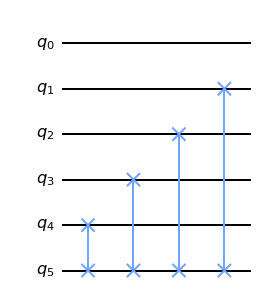

In [3]:
qct = transpile(qc)
qct.draw(output='mpl')

We can verify that `q2` is mapped to `q1`, `q3` is mapped to `q2`, and so on.

---

Under the hood, `PermutationGate`s are synthesized using `HighLevelSynthesis` transpiler pass. 

---

**Running HighLevelSynthesis directly**

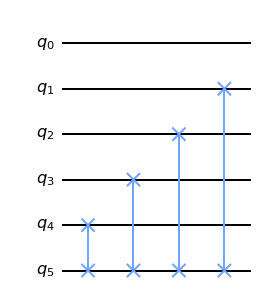

In [4]:
qct = HighLevelSynthesis()(qc)
qct.draw(output='mpl')

---

We have multiple algorithms (synthesis plugins) for synthesizing permutation gates

---

**Listing available synthesis algorithms**

In [5]:
print(HighLevelSynthesisPluginManager().method_names("permutation"))

['acg', 'basic', 'default', 'kms', 'token_swapper', 'sat_count', 'sat_depth']


**Some of these methods**

* 'basic': 
  * original Qiskit method (used for constructing permutation circuits)
  * assumes all-to-all connectivity
* 'acg': 
  * Alon, Chung, Graham method
  * assumes all-to-all connectivity
  * produces a quantum circuit of depth 2 (measured in the number of SWAPs)
* 'kms':
  * Kutin, Moulton, Smithline method
  * adheres to LNN (linear nearest-neighbor) connectivity
* 'token_swapper':
  * *NEW*, will be discussed shortly

**Synthesizing permutation gates using 'acg' plugin**

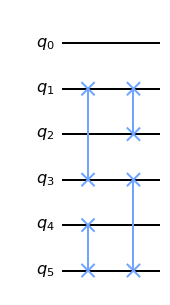

In [49]:
config = HLSConfig(permutation=["acg"])
qct = HighLevelSynthesis(hls_config=config)(qc)
qct.draw(output='mpl')

**Synthesizing permutation gates using 'kms' plugin**

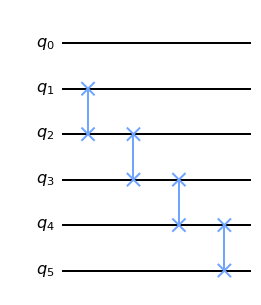

In [54]:
config = HLSConfig(permutation=["kms"])
qct = HighLevelSynthesis(hls_config=config)(qc)
qct.draw(output='mpl')

**Specifying synthesis plugin directly in transpile**

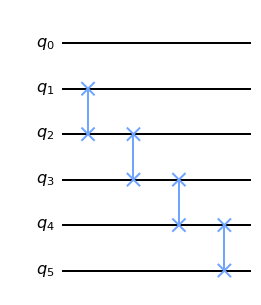

In [55]:
config = HLSConfig(permutation=["kms"])
qct = transpile(qc, hls_config=config)
qct.draw(output='mpl')

**HighLevelSynthesis typically runs before routing**

---

In all of the examples above, synthesis was done on the _logical circuit_, before layout/routing.

Note that we must unroll/synthesize 3q+ gates before routing.


---

**ApproximateTokenSwapper algorithm in Qiskit**

* An algorithm to synthesize permutations that works with arbitrary connectivity
* Described in the paper "Circuit Transformations for Quantum Architectures", by Andrew M. Childs, Eddie Schoute, Cem M. Unsal, 2019
* The code is in Qiskit for quite a while (called `ApproximateTokenSwapper`), the large part is implemented in Rustworkx 

### NEW: Extending `HighLevelSynthesis` and `HighLevelSynthesisPlugin` interface with target / coupling map support

* Reference: PR #10477 (merged) 



* Extends `HighLevelSynthesis` interface to support target / coupling map, in particular allowing to use connectivity-aware synthesis algorithms (plugins)

```
class HighLevelSynthesis(TransformationPass):

    def __init__(
        self,
        hls_config: Optional[HLSConfig] = None,
        coupling_map: Optional[CouplingMap] = None,
        target: Optional[Target] = None,
        use_qubit_indices: bool = False,
    )
```


* The argument `use_qubit_indices` provides the context to `HighLevelSynthesis` whether it's running before or after the layout has been set, that is, whether the qubit indices of higher-level-objects correspond to qubit indices on the target backend.


* Extends `HighLevelSynthesisPlugin` interface to take target/coupling map/qubits into account

```
class HighLevelSynthesisPlugin(abc.ABC):
    @abc.abstractmethod
    def run(self, high_level_object, coupling_map=None, target=None, qubits=None, **options):
        pass
```

* If synthesis is done before routing, `qubits` is `None`, and all-to-all connectivity is assumed.

* If synthesis is done after routing, both `qubits` and `coupling_map` are not `None`, and the synthesized circuit should adhere to connectivity constraints on specific qubits.

* A synthesis plugin is allowed to return `None` if it's unable to synthesize the circuit (with the given connectivity constraints, options, etc.)


---

**NEW: TokenSwapper synthesis plugin for `PermutationGate`s**

* Reference: PR #10657 (not merged). 

* Exposes the `ApproximateTokenSwapper` algorithm as a synthesis plugin for `PermutationGate`s. 
* This is the first Qiskit synthesis plugin that actually takes connectivity into account. 
* The PR requires Rustworkx release (this is why it is not merged).

---

### Let's experiment with the new functionality

---

**Run token swapper without connectivity constraints**

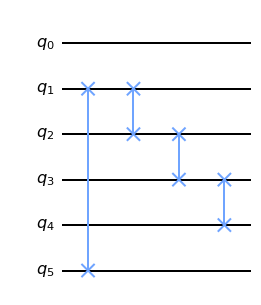

In [56]:
config = HLSConfig(permutation=["token_swapper"])
qct = HighLevelSynthesis(hls_config=config)(qc)
qct.draw(output='mpl')

**Run token swapper on a star-shaped graph centered at `q1`**

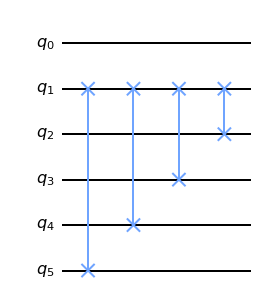

In [60]:
config = HLSConfig(permutation=["token_swapper"])
coupling_map = CouplingMap([[1, 2], [1, 3], [1, 4], [1, 5]])
qct = HighLevelSynthesis(hls_config=config, coupling_map=coupling_map, use_qubit_indices=True)(qc)
qct.draw(output='mpl')

**Run token swapper on a star-shaped graph centered at `q2`**

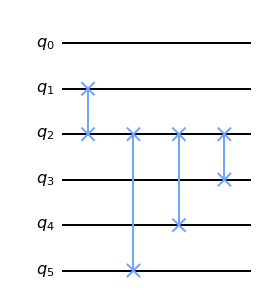

In [59]:
config = HLSConfig(permutation=["token_swapper"])
coupling_map = CouplingMap([[1, 2], [2, 3], [2, 4], [2, 5]])
qct = HighLevelSynthesis(hls_config=config, coupling_map=coupling_map, use_qubit_indices=True)(qc)
qct.draw(output='mpl')

**Run token swapper on a ring**

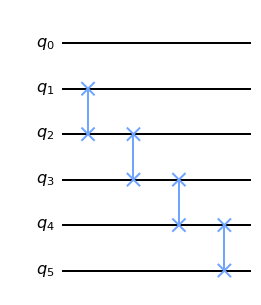

In [61]:
config = HLSConfig(permutation=["token_swapper"])
coupling_map = CouplingMap.from_ring(6)
qct = HighLevelSynthesis(hls_config=config, coupling_map=coupling_map, use_qubit_indices=True)(qc)
qct.draw(output='mpl')


**Token swapper plugin supports disconnected coupling maps**
* Returns SWAP-circuit when synthesis is possible
* Returns `None` when synthesis is impossible
  * `HighLevelSynthesis` leaves the permutation gate alone

---

**Example where synthesis is possible**

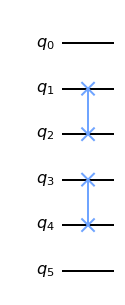

In [62]:
coupling_map = CouplingMap([[0, 1], [1, 2], [3, 4], [4, 5]])
config = HLSConfig(permutation=["token_swapper"])

qc = QuantumCircuit(6)
qc.append(PermutationGate([1, 0, 3, 2]), [1, 2, 3, 4])
config = HLSConfig(permutation=[("token_swapper", {"trials": 10})])
qct = HighLevelSynthesis(hls_config=config, coupling_map=coupling_map, use_qubit_indices=True)(qc)
qct.draw(output='mpl')

**Example when synthesis is not possible**

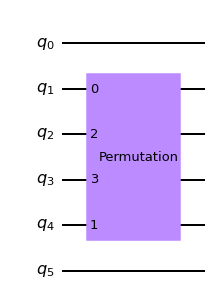

In [63]:
coupling_map = CouplingMap([[0, 1], [1, 2], [3, 4], [4, 5]])
config = HLSConfig(permutation=["token_swapper"])

qc = QuantumCircuit(6)
qc.append(PermutationGate([1, 0, 3, 2]), [1, 4, 2, 3])
config = HLSConfig(permutation=[("token_swapper", {"trials": 10})])
qct = HighLevelSynthesis(hls_config=config, coupling_map=coupling_map, use_qubit_indices=True)(qc)
qct.draw(output='mpl')

# Thanks! Questions?